In [76]:
!brew install libomp
!pip install seaborn

!pip install kagglehub
!pip install --upgrade category_encoders
!pip uninstall -y xgboost
!pip install xgboost
!pip install lightgbm

==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
To reinstall 20.1.3, run:
  brew reinstall libomp
Found existing installation: xgboost 3.0.0
Uninstalling xgboost-3.0.0:
  Successfully uninstalled xgboost-3.0.0
  Using cached xgboost-3.0.0-py3-none-macosx_10_15_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-macosx_10_15_x86_64.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.8 MB/s eta 0:00:00


In [77]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [80]:
# Data import
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

In [81]:
# Descipción de datos
df.describe()

age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.000000  
50%         5.800000           140.000000       0.000000  
75%         6.200000           159.000000       0.000000  
max         9.000000           300.000000       1.000000

In [82]:
df.shape

(100000, 9)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [84]:
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [85]:
# Count the number of rows where gender is not 'Other'
count_without_other = df[df['gender'] != 'Other'].shape[0]
print(f"Number of rows without 'Other' in gender: {count_without_other}")

Number of rows without 'Other' in gender: 99982


In [86]:
# Drop rows where the 'gender' column has the value 'Other'
df = df[df['gender'] != 'Other']

In [87]:
# Convertimos genero Hombre, Mujer, a 1, 0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [88]:
# Validamos si tenemos valore vacíos
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

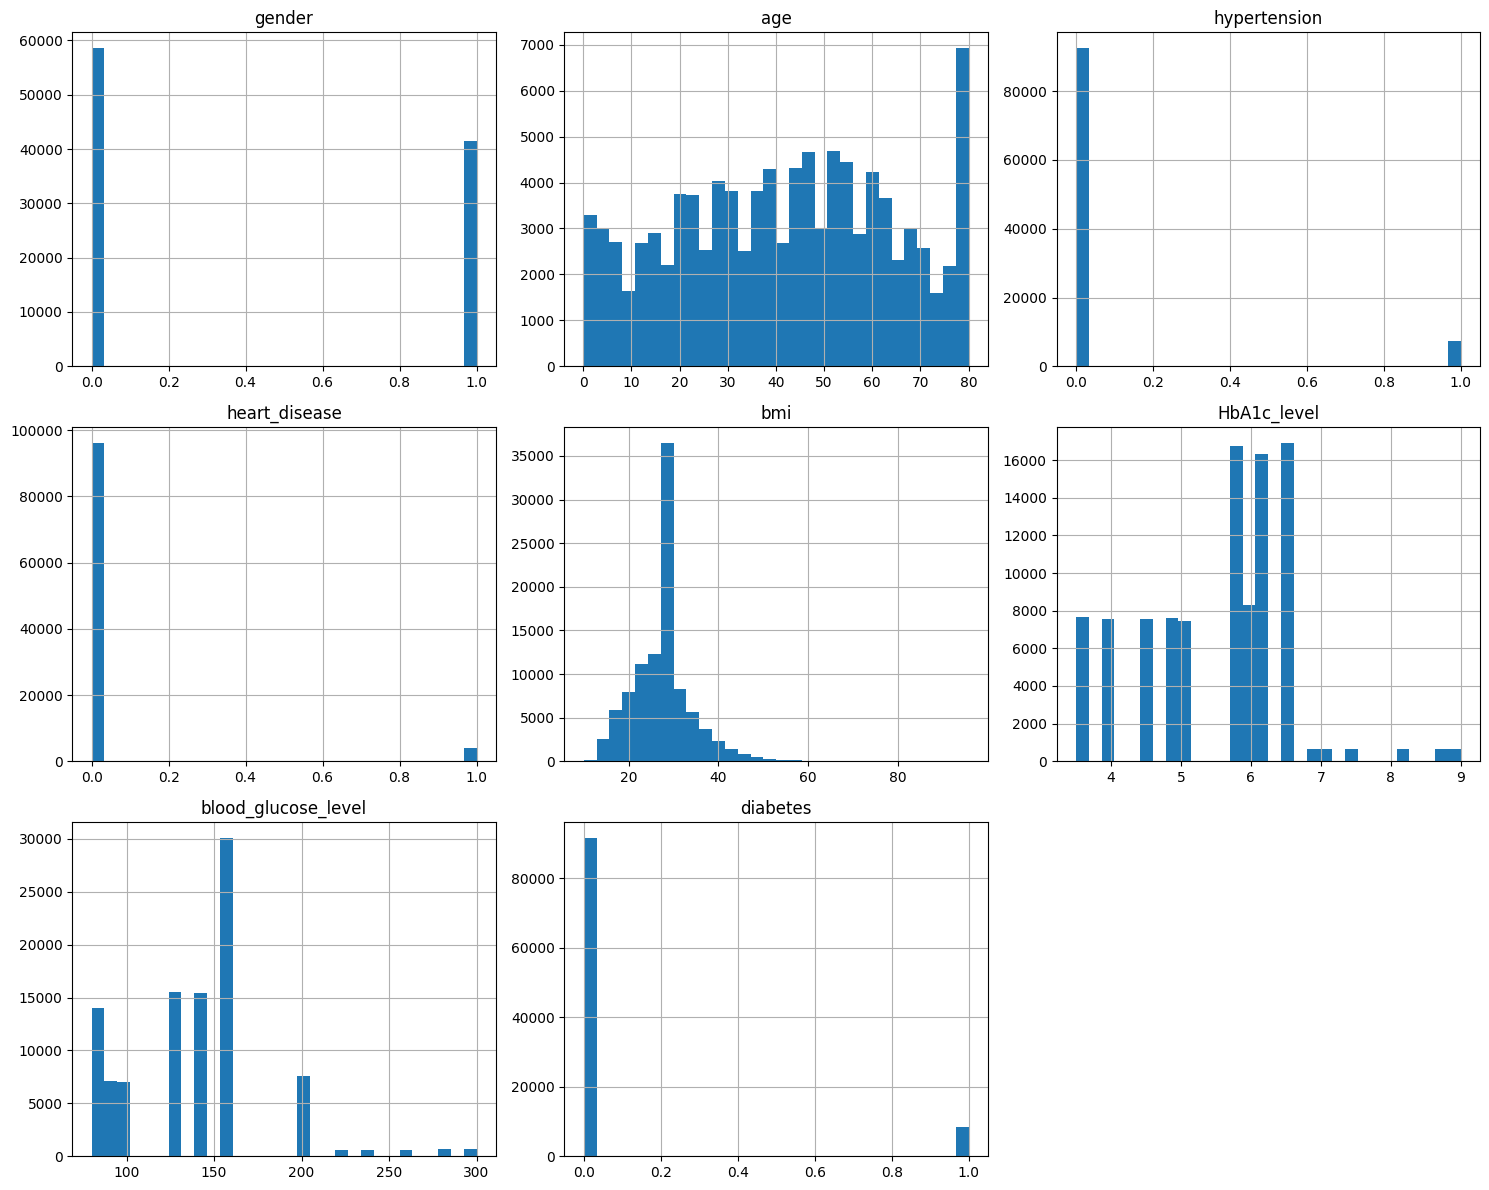

In [89]:
df.hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()

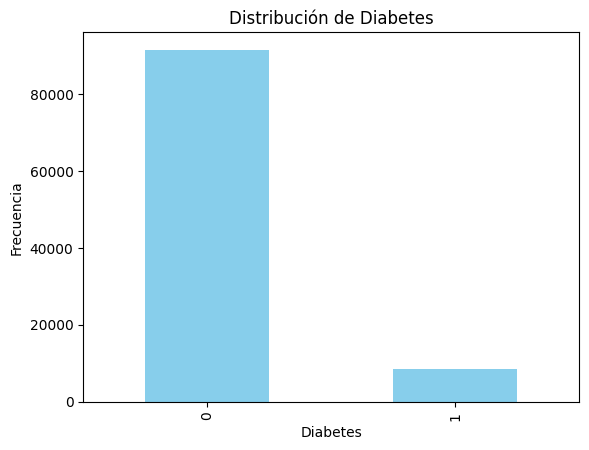

In [90]:
# Ahora vemos el conteo de nuestra variable objetivo: Diabetes

df['diabetes'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Frecuencia')
plt.show()

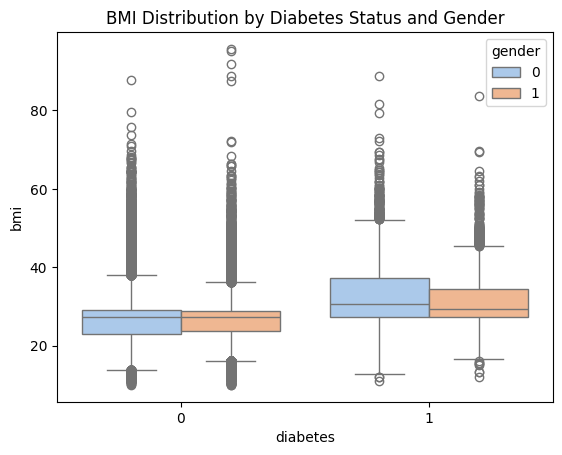

In [91]:
# Y nuestra variable contrastada contra el género e índice de masa corporal

sns.boxplot(data=df, x='diabetes', y='bmi', hue='gender', palette='pastel')
plt.title('BMI Distribution by Diabetes Status and Gender')
plt.show()

In [92]:
df.duplicated().sum()

np.int64(3854)

In [93]:
df = df.drop_duplicates()

In [94]:
df.duplicated().sum()

np.int64(0)

In [95]:
df.shape

(96128, 9)

In [96]:
df.sample(10)

gender   age  hypertension  heart_disease smoking_history    bmi  \
4481        1  71.0             1              0          former  27.54   
59051       0   4.0             0              0           never  16.20   
3982        1  43.0             0              0           never  19.50   
27056       0  27.0             0              0         No Info  27.32   
63728       0   5.0             0              0         No Info  17.37   
70194       0  16.0             0              0         No Info  21.69   
33828       1  80.0             0              1          former  23.40   
54349       0  52.0             0              0         No Info  27.32   
94684       0  20.0             0              0           never  29.05   
56819       1  15.0             0              0         No Info  20.81   

       HbA1c_level  blood_glucose_level  diabetes  
4481           6.6                  145         0  
59051          4.0                  126         0  
3982           5.7                  100         0  
27056          6.0                  159         0  
63728          4.0                  155         0  
70194          5.7                  200         0  
33828          6.0                  130         0  
54349          6.6                  126         1  
94684          6.0                  159         0  
56819          6.2                  160         0

In [97]:
unique_values = df['smoking_history'].unique()

In [98]:
#binary_transformer = Pipeline(
#    steps=[("binary_encoder", BinaryEncoder(cols=['smoking_history']))]
#)
df_encoded = pd.get_dummies(df, columns=['smoking_history'], prefix='smoking')

In [99]:
#df_encoded = binary_transformer.fit_transform(df)

In [100]:
#smoking_mapping = {}
#for i, col in enumerate(df_encoded):
#    clean_name = f"smoking_{unique_values[i].lower().replace(' ', '_')}"
#    smoking_mapping[col] = clean_name
smoking_mapping = {col: col for col in df_encoded.columns if col.startswith('smoking_')}

In [ ]:
df_encoded = df_encoded.rename(columns=smoking_mapping)
df.columns = df.columns.str.replace(r'\s+', '_', regex=True)
print("\nSample of data with renamed columns:")
df_encoded.sample(5)


Sample of data with renamed columns:


gender    age  hypertension  heart_disease    bmi  HbA1c_level  \
3094        0  38.00             0              0  27.32          5.0   
48924       0   1.08             0              0  27.32          3.5   
87765       0  65.00             0              0  36.98          3.5   
77200       0  66.00             0              0  25.15          6.1   
58290       0  35.00             0              0  30.80          6.2   

       blood_glucose_level  diabetes  smoking_No Info  smoking_current  \
3094                   159         0             True            False   
48924                  100         0             True            False   
87765                  155         0             True            False   
77200                  200         0             True            False   
58290                  159         0            False            False   

       smoking_ever  smoking_former  smoking_never  smoking_not current  
3094          False           False          False                False  
48924         False           False          False                False  
87765         False           False          False                False  
77200         False           False          False                False  
58290         False            True          False                False

In [103]:
def cap_outliers(df_encoded, column):
    Q1 = df_encoded[column].quantile(0.25)
    Q3 = df_encoded[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_encoded[column] = df_encoded[column].clip(lower_bound, upper_bound)
    return df_encoded

for col in ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    df_encoded = cap_outliers(df_encoded, col)

In [104]:
scaler = StandardScaler()
df_encoded[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(
    df_encoded[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
)

In [105]:
df_encoded.dtypes

gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level    float64
diabetes                 int64
smoking_No Info           bool
smoking_current           bool
smoking_ever              bool
smoking_former            bool
smoking_never             bool
smoking_not current       bool
dtype: object

Generating Pair Plot...


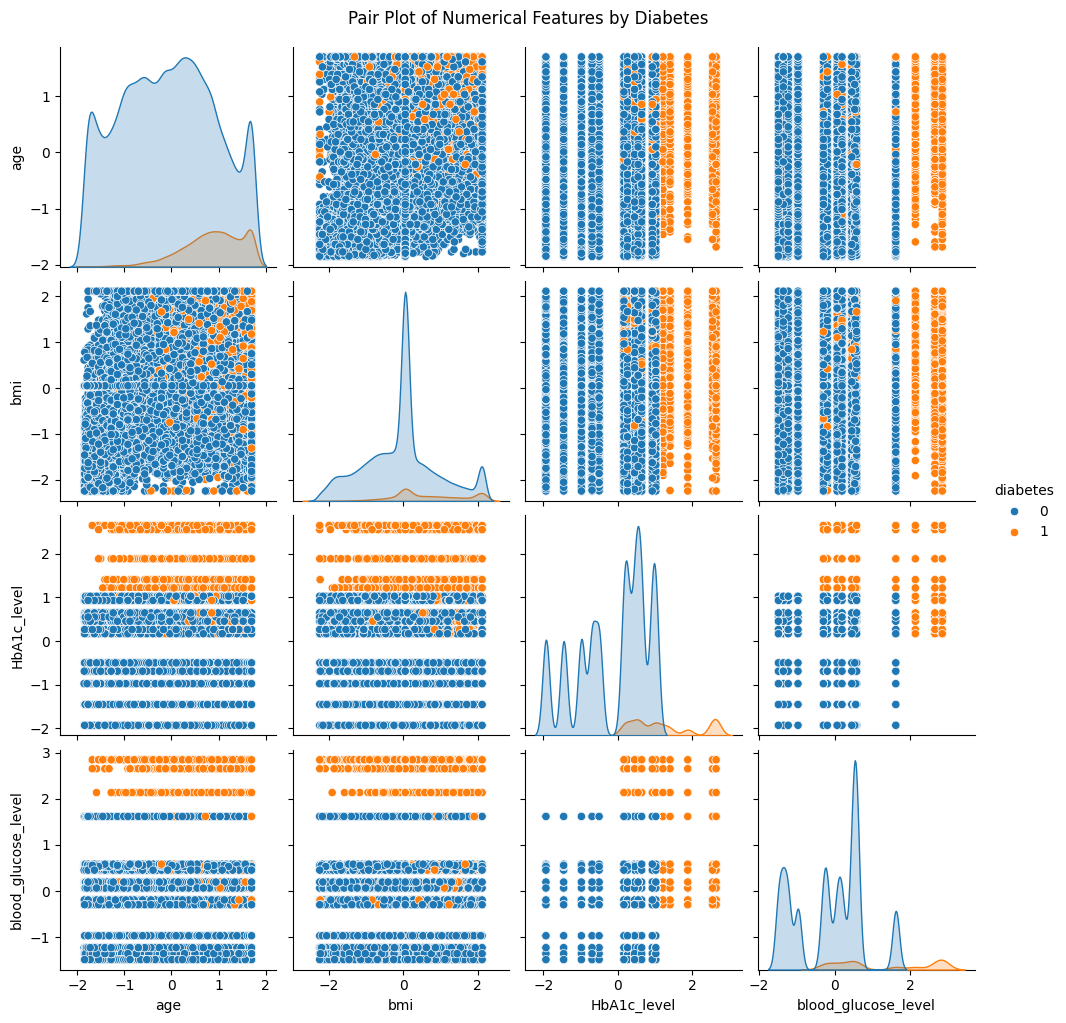

In [106]:
print("Generating Pair Plot...")
sns.pairplot(df_encoded[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']], 
             hue='diabetes', diag_kind='kde')
plt.suptitle('Pair Plot of Numerical Features by Diabetes', y=1.02)
plt.show()

Generating Box Plots...


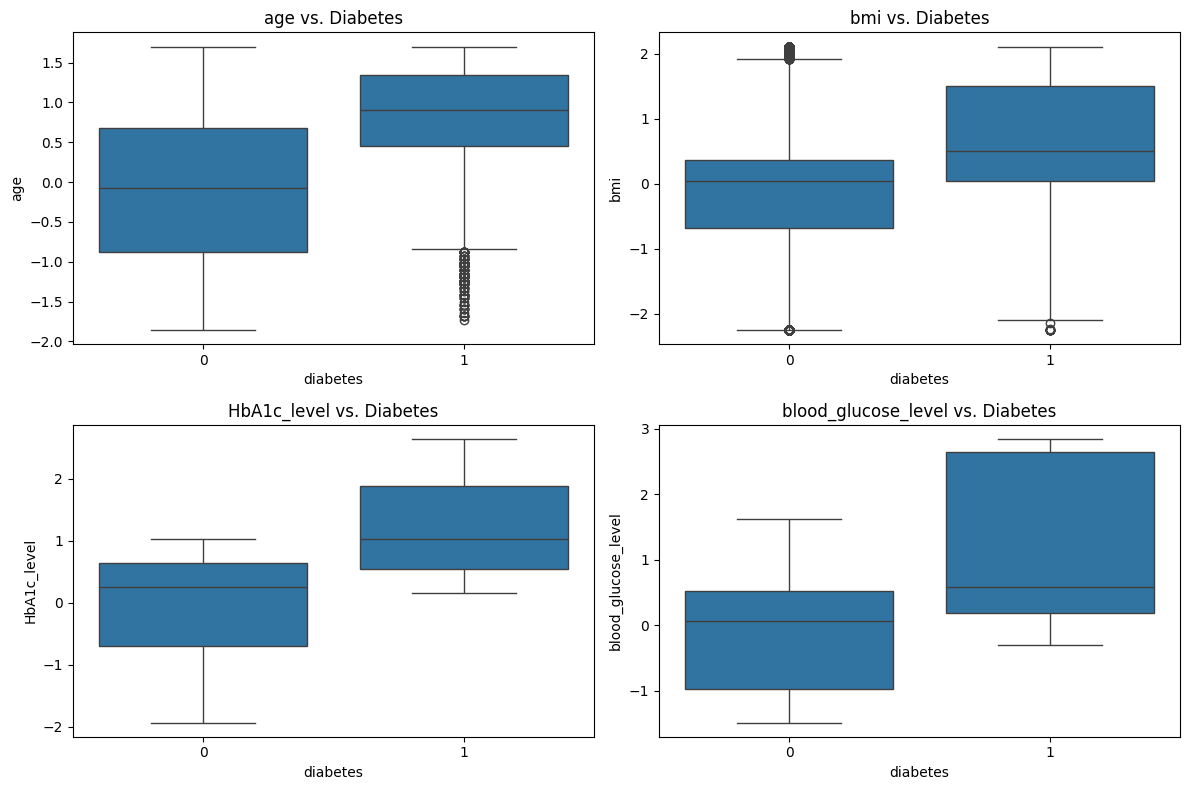

In [107]:
print("Generating Box Plots...")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for i, col in enumerate(numerical_cols):
    sns.boxplot(x='diabetes', y=col, data=df_encoded, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col} vs. Diabetes')
plt.tight_layout()
plt.show()

Generating Count Plots...


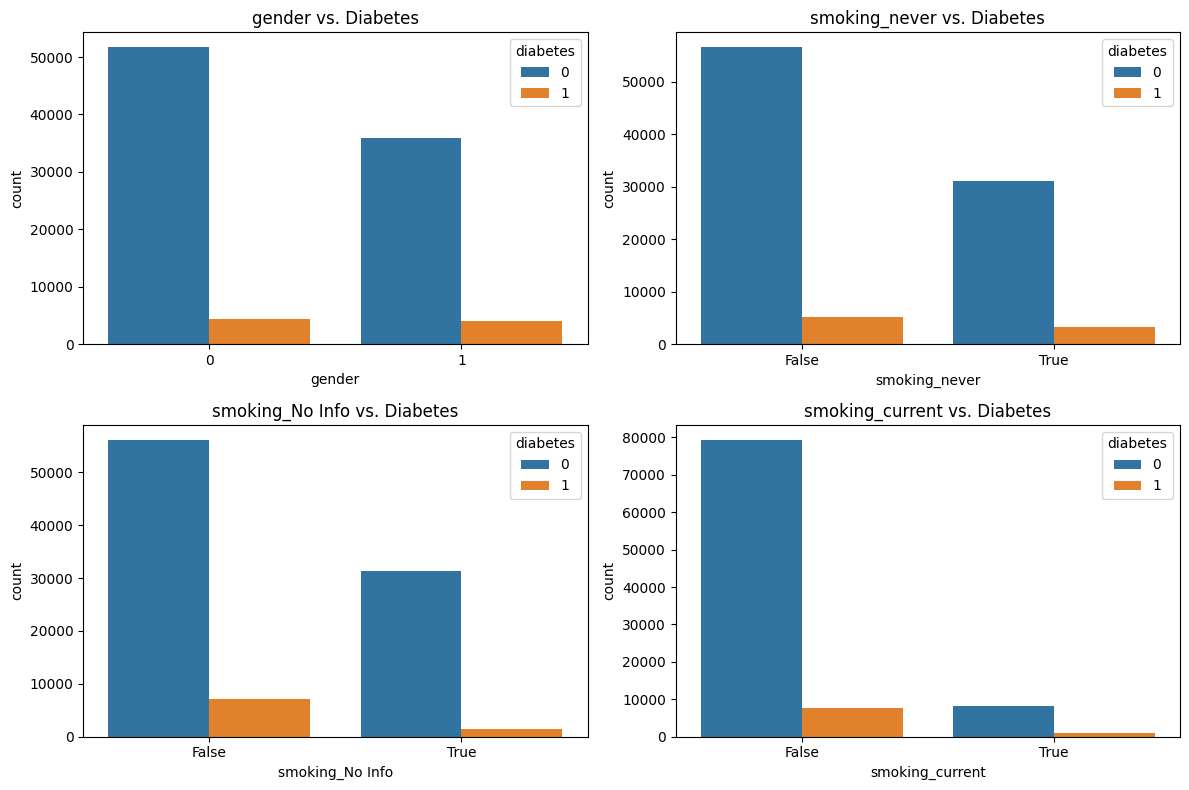

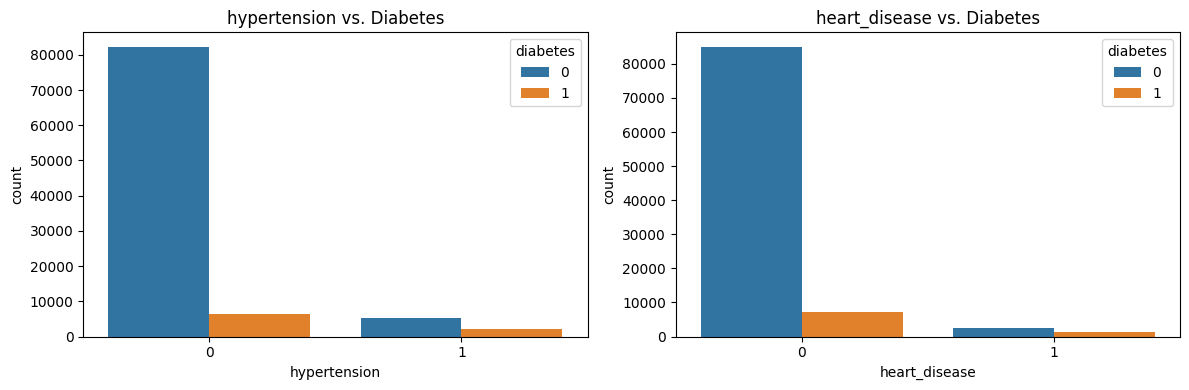

In [108]:
print("Generating Count Plots...")
categorical_cols = ['gender', 'smoking_never', 'smoking_No Info', 'smoking_current', 'hypertension', 'heart_disease']

# First figure with first 4 plots
fig1, axes1 = plt.subplots(2, 2, figsize=(12, 8))
axes1 = axes1.flatten()  # Flatten for easier indexing

for i in range(min(4, len(categorical_cols))):
    sns.countplot(x=categorical_cols[i], hue='diabetes', data=df_encoded, ax=axes1[i])
    axes1[i].set_title(f'{categorical_cols[i]} vs. Diabetes')

plt.tight_layout()
plt.show()

# Second figure with remaining plots
if len(categorical_cols) > 4:
    fig2, axes2 = plt.subplots(1, len(categorical_cols)-4, figsize=(12, 4))
    if len(categorical_cols) == 5:  # Handle case of just one subplot
        axes2 = [axes2]
        
    for i in range(4, len(categorical_cols)):
        sns.countplot(x=categorical_cols[i], hue='diabetes', data=df_encoded, ax=axes2[i-4])
        axes2[i-4].set_title(f'{categorical_cols[i]} vs. Diabetes')
    
    plt.tight_layout()
    plt.show()

In [109]:
print("Diabetes Class Distribution:")
print(df_encoded['diabetes'].value_counts())

Diabetes Class Distribution:
diabetes
0    87646
1     8482
Name: count, dtype: int64


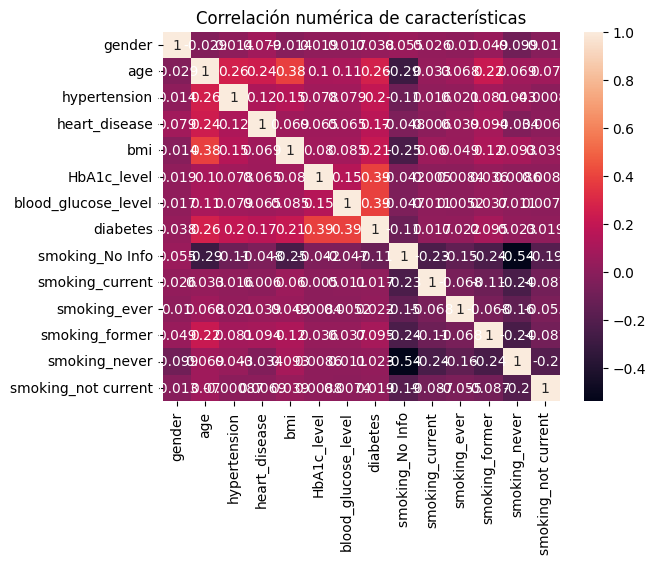

In [110]:
# Ahora vemos la correlación entre los datos

num_df = df_encoded.select_dtypes(exclude='object')
fig, ax = plt.subplots()
sns.heatmap(num_df.corr(), annot=True)
plt.title('Correlación numérica de características')
plt.show()

In [111]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    },
    'Gradient Boost': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [-1, 10, 20],              # -1 means no limit
            'learning_rate': [0.01, 0.1, 0.2],
            'num_leaves': [15, 31, 63],             # 31 is default
            'min_child_samples': [10, 20, 50],      # minimum number of samples per leaf
            'subsample': [0.8, 1.0],                # row sampling
            'colsample_bytree': [0.8, 1.0]          # feature sampling
    }
    }
}

In [117]:
from sklearn.model_selection import GridSearchCV

results = []
hyperparameters = {}

for name, config in models.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({'Model': name, 'Accuracy': accuracy})
    hyperparameters[name] = grid.best_params_
    
    print(f"Best Parameters for {name}: {grid.best_params_}")
    print(f"Test Accuracy: {accuracy:.3f}")


Training Logistic Regression...
Best Parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Test Accuracy: 0.956

Training Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 50}
Test Accuracy: 0.969

Training XGBoost...
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Test Accuracy: 0.969

Training Gradient Boost...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5425, number of negative: 56097
[LightGBM] [Info] Number of positive: 5425, number of negative: 56097
[LightGBM] [Info] Number of positive: 5424, number of

In [118]:
# prompt: number of values equals to 1 in the column diabetes
count_diabetes_1 = df[df['diabetes'] == 1]['diabetes'].count()
print(f"Number of values equal to 1 in the 'diabetes' column: {count_diabetes_1}")


Number of values equal to 1 in the 'diabetes' column: 8482


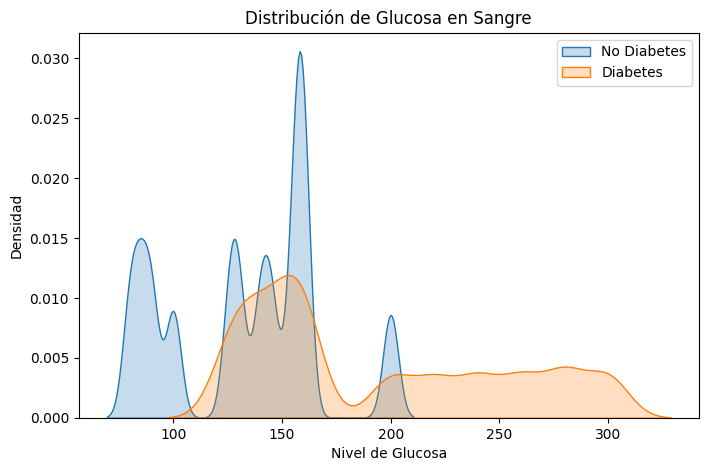

In [119]:
# Relacion entre variable dependiente y la glucosa en sangre como independiente

plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['diabetes'] == 0]['blood_glucose_level'], label='No Diabetes', fill=True)
sns.kdeplot(df[df['diabetes'] == 1]['blood_glucose_level'], label='Diabetes', fill=True)
plt.title('Distribución de Glucosa en Sangre')
plt.xlabel('Nivel de Glucosa')
plt.ylabel('Densidad')
plt.legend()
plt.show()

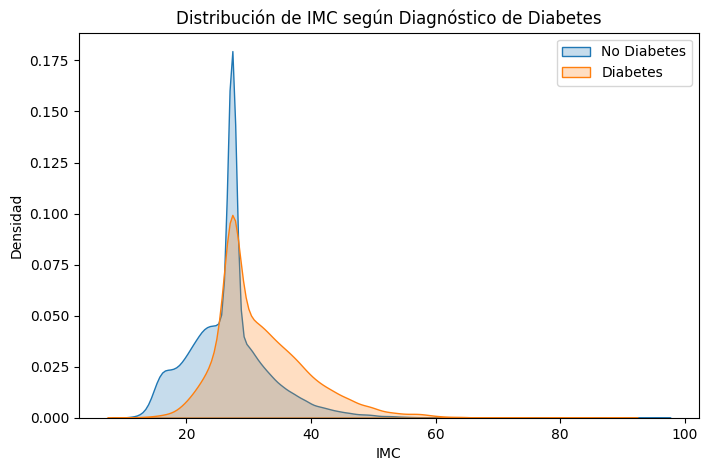

In [120]:
# Relacion entre variable dependiente e índice de masa corporal como independiente

plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['diabetes'] == 0]['bmi'], label='No Diabetes', fill=True)
sns.kdeplot(df[df['diabetes'] == 1]['bmi'], label='Diabetes', fill=True)
plt.title('Distribución de IMC según Diagnóstico de Diabetes')
plt.xlabel('IMC')
plt.ylabel('Densidad')
plt.legend()
plt.show()

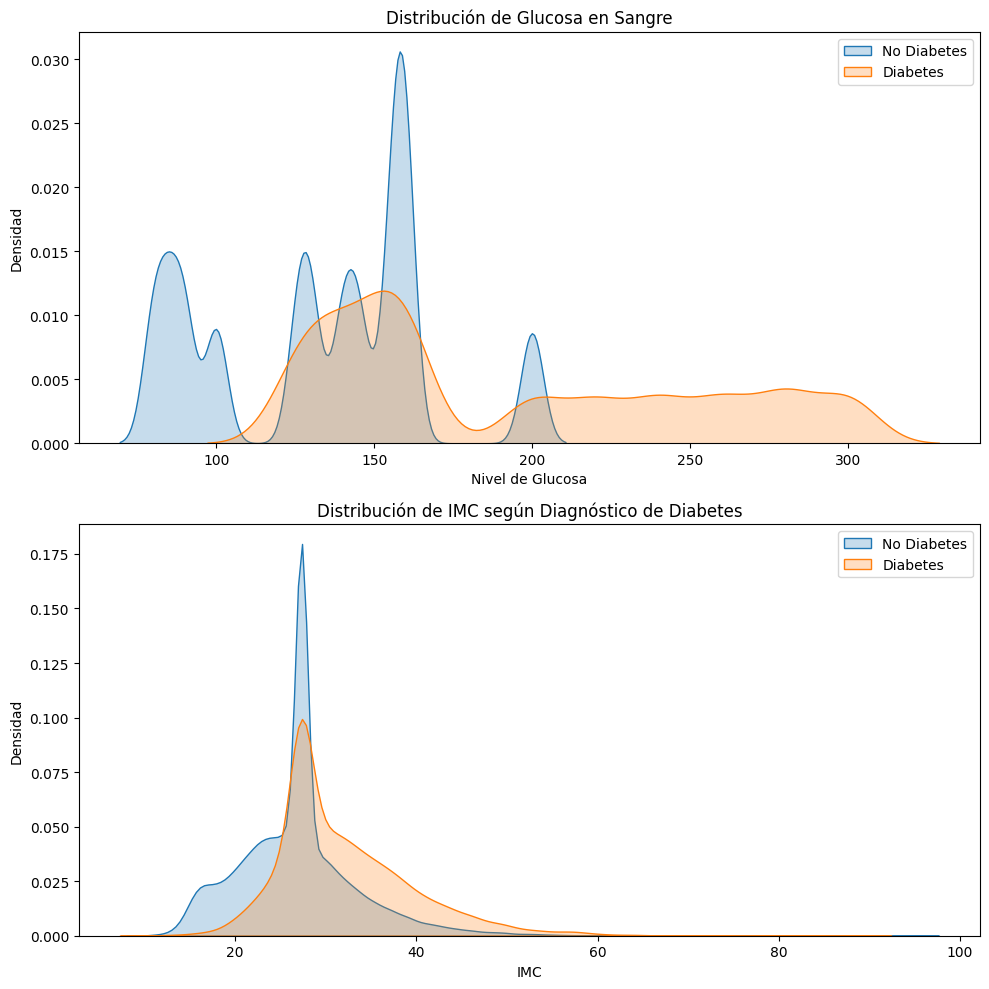

Exception ignored in: <function ResourceTracker.__del__ at 0x10e54d3a0>
Traceback (most recent call last):
  File "/Users/jarestrepogu/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/jarestrepogu/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/jarestrepogu/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10db3d3a0>
Traceback (most recent call last):
  File "/Users/jarestrepogu/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/jarestrepogu/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/jarestrepogu/.pyenv/versions/3.13.3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, i

In [121]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 filas, 1 columna

# --- Gráfico 1: Distribución de Glucosa en Sangre ---
sns.kdeplot(
    data=df[df['diabetes'] == 0]['blood_glucose_level'],
    label='No Diabetes',
    fill=True,
    ax=axs[0]
)
sns.kdeplot(
    data=df[df['diabetes'] == 1]['blood_glucose_level'],
    label='Diabetes',
    fill=True,
    ax=axs[0]
)
axs[0].set_title('Distribución de Glucosa en Sangre')
axs[0].set_xlabel('Nivel de Glucosa')
axs[0].set_ylabel('Densidad')
axs[0].legend()

# --- Gráfico 2: Distribución de IMC ---
sns.kdeplot(
    data=df[df['diabetes'] == 0]['bmi'],
    label='No Diabetes',
    fill=True,
    ax=axs[1]
)
sns.kdeplot(
    data=df[df['diabetes'] == 1]['bmi'],
    label='Diabetes',
    fill=True,
    ax=axs[1]
)
axs[1].set_title('Distribución de IMC según Diagnóstico de Diabetes')
axs[1].set_xlabel('IMC')
axs[1].set_ylabel('Densidad')
axs[1].legend()

# Ajustar espacios
plt.tight_layout()
plt.show()